In [21]:
import tqdm
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from collections import Counter
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
dataset_path = "./lfw-deepfunneled/lfw-deepfunneled/"

# Load Data

In [22]:
all_image_df = pd.read_csv(r'./unbalancedDev.csv')
all_names_df = pd.read_csv(r'./lfw_allnames.csv')
all_names_df['images'] = pd.to_numeric(all_names_df['images'])
all_image_df

,name,images
0,Aaron_Peirsol,4
1,Aaron_Sorkin,2
2,Abdel_Nasser_Assidi,2
3,Abdoulaye_Wade,4
4,Abdullah,4
...,...,...
1675,Zhang_Ziyi,4
1676,Zhu_Rongji,9
1677,Zico,3
1678,Zinedine_Zidane,6


# Define Data Processing Functions

In [23]:
def format_number(number):
    return "{:04d}".format(number)


def get_train_test_pic_name(df):
    train_pic_name_lst = []
    test_pic_name_lst = []

    for _, row in df.iterrows():
        person_name = row['name']
        images = row['images']

        # Training images: all but the last image
        train_pic_name_lst.extend([
            f"{person_name}/{person_name}_{format_number(i)}.jpg" for i in range(1, images)
        ])

        # Testing image: the last image
        test_pic_name_lst.append(f"{person_name}/{person_name}_{format_number(images)}.jpg")

    return train_pic_name_lst, test_pic_name_lst


def get_balance_pic_name(df, appearance):
    train_pic_name_lst = []
    int_part, decimal_part = divmod(appearance, 1)

    for _, row in df.iterrows():
        person_name = row['name']
        images = row['images']
        
        pic_nums = []
        
        for i in range(int(int_part)):
            pic_nums.append(random.randint(1, images-1))
        if random.random() < decimal_part:
            pic_nums.append(random.randint(1, images-1))

        train_pic_name_lst.extend([
            f"{person_name}/{person_name}_{format_number(i)}.jpg" for i in pic_nums
        ])

    return train_pic_name_lst


def prepare_labels(pic_names):
    labels = [pic_name.split('/')[0] for pic_name in pic_names]
    return labels


def encode_labels(labels):
    # Step 1: Convert each unique label string to a unique integer
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)

    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    one_hot_encoder = OneHotEncoder(sparse=False)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    label_indices = np.argmax(one_hot_encoded, axis=1)
    label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

    return label_indices, label_mapping


def average_appearance(names):
    name_counts = Counter(names)
    total_occurrences = sum(name_counts.values())
    unique_names = len(name_counts)
    total_average = total_occurrences / unique_names

    return total_average

# Testing Models 

## Customized CNN

In [24]:
import torch.nn as nn
import torch.nn.functional as F
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Use the first GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using CPU")

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Input size: (3, 250, 250)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 31 * 31, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1680)  # 1680 classes for classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 31 * 31)  # Flatten the layer
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Using GPU: NVIDIA GeForce RTX 4070 SUPER


## Customized Dataset

In [25]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image


class CustomImageDataset(Dataset):
    def __init__(self, image_names, labels, root_dir, transform=None, tilt_degree=10):
        """
        Args:
            image_names (list): List of image file names.
            labels (list): List of labels for the images.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            tilt_degree (int): Degree range for random tilt. Image will be randomly rotated within (-tilt_degree, +tilt_degree).
        """
        self.image_names = image_names
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        self.random_tilt = transforms.RandomRotation(degrees=(-tilt_degree, tilt_degree))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_names[idx])
        image = Image.open(img_name).convert('RGB')  # Ensure image is in RGB format
        label = self.labels[idx]

        image = self.random_tilt(image)

        if self.transform:
            image = self.transform(image)

        return image, label

## Preparing Data

In [26]:
unbalanced_train_pic_names, test_pic_names = get_train_test_pic_name(all_image_df)
appearance = average_appearance([s.split('/')[0] for s in unbalanced_train_pic_names])
balance_train_pic_names = get_balance_pic_name(all_image_df, appearance)

In [27]:
unbalanced_train_labels = prepare_labels(unbalanced_train_pic_names)
balance_train_labels    = prepare_labels(balance_train_pic_names)
test_labels             = prepare_labels(test_pic_names)
one_hot_train_labels, train_label_map = encode_labels(unbalanced_train_labels)
balance_one_hot_train_labels, _       = encode_labels(balance_train_labels)
one_hot_test_labels, test_label_map   = encode_labels(test_labels)

In [28]:
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split

simple_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image data to PyTorch tensors and scales [0, 255] -> [0.0, 1.0]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizes tensor to [-1.0, 1.0]
])

unbalanced_train_dataset = CustomImageDataset(image_names=unbalanced_train_pic_names, 
                                        labels=one_hot_train_labels.tolist(), 
                                        root_dir=dataset_path, 
                                        transform=simple_transform)
balanced_train_dataset   = CustomImageDataset(image_names=balance_train_pic_names, 
                                        labels=balance_one_hot_train_labels.tolist(), 
                                        root_dir=dataset_path,
                                        transform=simple_transform)
test_dataset             = CustomImageDataset(image_names=test_pic_names, 
                                        labels=one_hot_test_labels, 
                                        root_dir=dataset_path, 
                                        transform=simple_transform)

# Define the size of the validation set for each dataset
validation_size_unbalanced = int(0.2 * len(unbalanced_train_dataset))
validation_size_balanced   = int(0.2 * len(balanced_train_dataset))

train_size_unbalanced = len(unbalanced_train_dataset) - validation_size_unbalanced
train_size_balanced   = len(balanced_train_dataset) - validation_size_balanced

unbalanced_train_subset, unbalanced_valid_subset = random_split(unbalanced_train_dataset, [train_size_unbalanced, validation_size_unbalanced])
balanced_train_subset, balanced_valid_subset     = random_split(balanced_train_dataset, [train_size_balanced, validation_size_balanced])

In [29]:
unbalanced_train_loader = DataLoader(unbalanced_train_subset, batch_size=32, shuffle=True)
unbalanced_valid_loader = DataLoader(unbalanced_valid_subset, batch_size=32, shuffle=True)
balanced_train_loader   = DataLoader(balanced_train_subset, batch_size=32, shuffle=True)
balanced_valid_loader   = DataLoader(balanced_valid_subset, batch_size=32, shuffle=True)
test_loader             = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Training Testing loop

In [30]:
import os
from tqdm import tqdm
from torch.nn.functional import softmax
    

def train_loop(model, criterion, optimizer, train_loader, valid_loader, num_epochs = 10, print_detail = False):
    train_loss = []
    valid_loss = []
    best_val_loss = float('inf')

    total_steps = num_epochs * len(train_loader)
    progress_bar = tqdm(range(total_steps))
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            progress_bar.update(1)
            
        temp_train_loss = running_loss / len(train_loader)
        train_loss.append(temp_train_loss)
    
        
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
    
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                probabilities = softmax(outputs, dim=1)
                max_probs, predicted = torch.max(probabilities, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if print_detail:
                    for max_prob, predict, actual in zip(max_probs, predicted, labels):
                        tqdm.write(f"max_prob: {max_prob}, predict: {predict}, actual: {actual}")


        val_loss = val_running_loss / len(valid_loader)
        val_acc = 100 * correct / total
        valid_loss.append(val_loss)
        
        if val_loss > best_val_loss:
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 2
        else:
            best_val_loss = val_loss
        current_lr = optimizer.param_groups[0]["lr"]
            
        progress_bar.set_postfix(epoch=f'{epoch+1}/{num_epochs}', 
                                 train_loss=f'{temp_train_loss:.4f}',
                                 valid_loss=f'{val_loss:.4f}', 
                                 valid_acc=f'{val_acc:.2f}%',
                                 lr=f'{current_lr}')
    
    print('Finished Training')
        
    return train_loss, valid_loss


def test_loop(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    confidences = []
    predictions = []
    
    with torch.no_grad():  # Disable gradient computation
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
    
            probabilities = softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probabilities, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            confidences.extend(max_probs.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
    
    # Calculate and print the accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    
    return confidences, predictions, accuracy

## Lose Curve Plot Function

In [31]:
def plot_loss_changes(train_loss_list, valid_loss_list):
    """
    Plots the changes in training and validation loss over iterations or epochs on the same graph.
    
    Parameters:
    - train_loss_list: A list of training loss values, typically recorded after each training epoch or iteration.
    - valid_loss_list: A list of validation loss values, typically recorded after each validation step.
    """
    plt.figure(figsize=(10, 6))
    # Plotting training loss
    plt.plot(train_loss_list, label='Training Loss', marker='o', linestyle='-', color='b')
    # Plotting validation loss
    plt.plot(valid_loss_list, label='Validation Loss', marker='x', linestyle='--', color='r')

    plt.title('Training and Validation Loss Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()

## Unbalanced Dataset Custom Model Train & Test

In [58]:
custom_unbalance_model = CustomCNN()  # The model defined in previous examples
custom_unbalance_model = custom_unbalance_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_unbalance_model.parameters(), lr=0.001)

custom_unbalance_train_loss, custom_unbalance_valid_loss = train_loop(custom_unbalance_model, criterion, optimizer, unbalanced_train_loader, unbalanced_valid_loader)


100%|██████████| 1880/1880 [05:33<00:00,  5.64it/s, epoch=10/10, lr=1.953125e-06, train_loss=6.3274, valid_acc=7.35%, valid_loss=6.7055]

Finished Training


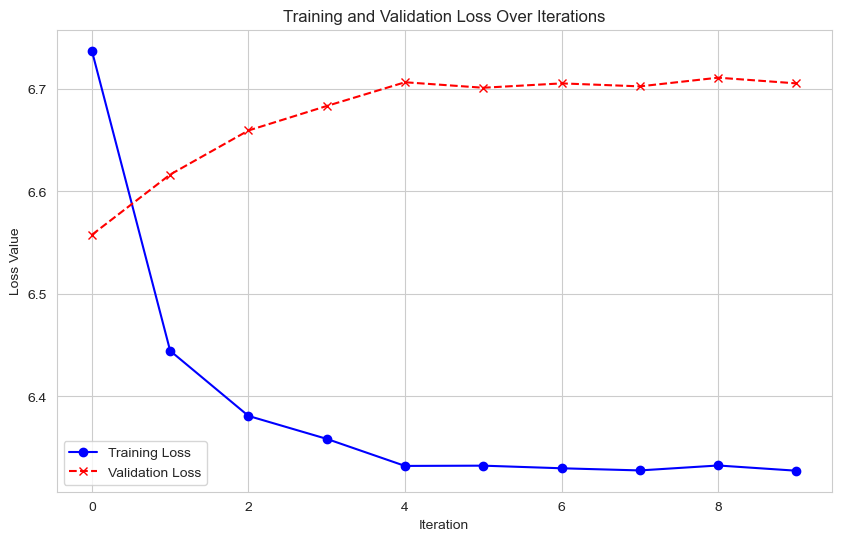

In [59]:
plot_loss_changes(custom_unbalance_train_loss, custom_unbalance_valid_loss)

In [60]:
custom_unbalance_conf, custom_unbalance_prob, custom_unbalance_acc = test_loop(custom_unbalance_model, test_loader)


100%|██████████| 53/53 [00:04<00:00, 10.89it/s]

Accuracy of the model on the test images: 0.06%


## Balanced Dataset Custom Model Train & Test

In [61]:
custom_balance_model = CustomCNN()  # The model defined in previous examples
custom_balance_model = custom_balance_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_balance_model.parameters(), lr=0.001)

custom_balance_train_loss, custom_balance_valid_loss = train_loop(custom_balance_model, criterion, optimizer, balanced_train_loader, balanced_valid_loader)


100%|██████████| 1880/1880 [05:41<00:00,  5.51it/s, epoch=10/10, lr=6.25e-05, train_loss=4.3200, valid_acc=28.80%, valid_loss=5.6880]

Finished Training


In [64]:
train_loss, valid_loss = train_loop(custom_balance_model, criterion, optimizer, balanced_train_loader, balanced_valid_loader)
custom_balance_train_loss.extend(train_loss)
custom_balance_valid_loss.extend(valid_loss)


100%|██████████| 1880/1880 [05:36<00:00,  5.58it/s, epoch=10/10, lr=7.8125e-06, train_loss=0.8734, valid_acc=70.47%, valid_loss=4.6873]

Finished Training


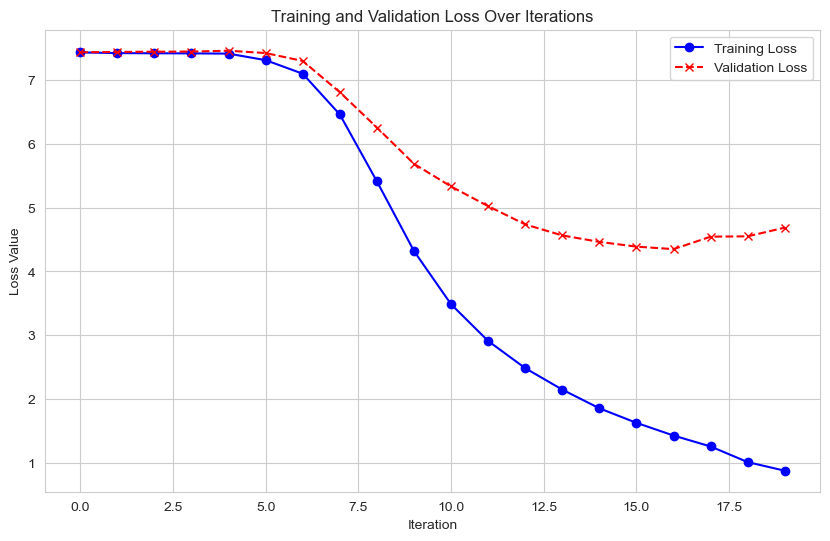

In [65]:
plot_loss_changes(custom_balance_train_loss, custom_balance_valid_loss)

In [66]:
custom_balance_conf, custom_balance_prob, custom_balance_acc = test_loop(custom_balance_model, test_loader)


100%|██████████| 53/53 [00:05<00:00,  9.22it/s]

Accuracy of the model on the test images: 1.85%


## Unbalanced Dataset Pretrained Model Train & Test

In [41]:
import torchvision.models as models
from torchvision.models.resnet import ResNet34_Weights
num_classes = len(test_labels)

In [44]:
pretrained_unbalance_model = models.resnet34(weights=ResNet34_Weights.DEFAULT)
num_ftrs = pretrained_unbalance_model.fc.in_features
pretrained_unbalance_model.fc = nn.Linear(num_ftrs, num_classes)
pretrained_unbalance_model = pretrained_unbalance_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_unbalance_model.parameters(), lr=0.01, momentum=0.9)

for param in pretrained_unbalance_model.parameters():
    param.requires_grad = False

for param in pretrained_unbalance_model.fc.parameters():
    param.requires_grad = True

pretrained_unbalance_train_loss, pretrained_unbalance_valid_loss = train_loop(pretrained_unbalance_model, criterion, optimizer, unbalanced_train_loader, unbalanced_valid_loader)


100%|██████████| 1880/1880 [04:01<00:00,  7.80it/s, epoch=10/10, lr=0.01, train_loss=2.8123, valid_acc=29.08%, valid_loss=4.9188]

Finished Training


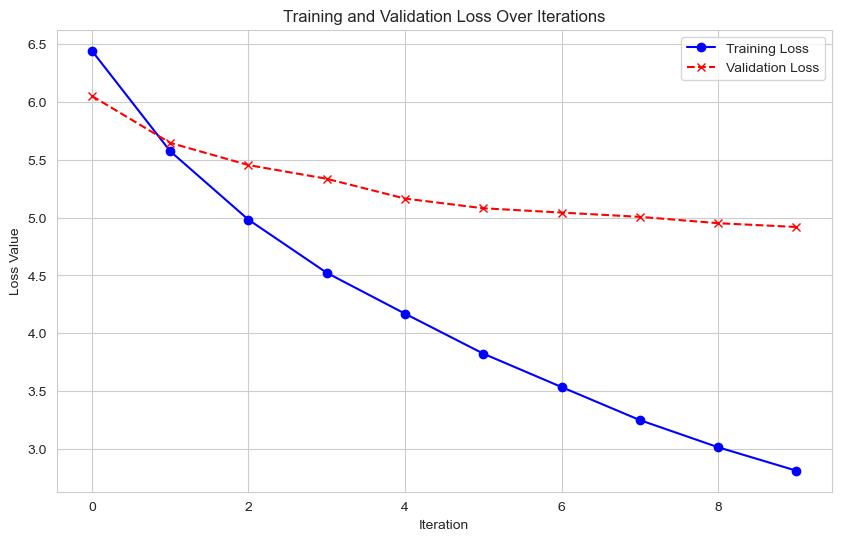

In [45]:
plot_loss_changes(pretrained_unbalance_train_loss, pretrained_unbalance_valid_loss)

In [46]:
pretrained_unbalance_conf, pretrained_unbalance_prob, pretrained_unbalance_acc = test_loop(pretrained_unbalance_model, test_loader)


100%|██████████| 53/53 [00:05<00:00, 10.35it/s]

Accuracy of the model on the test images: 4.23%


## Balanced Dataset Pretrained Model Train & Test

In [47]:
pretrained_balance_model = models.resnet34(weights=ResNet34_Weights.DEFAULT)
num_ftrs = pretrained_balance_model.fc.in_features
pretrained_balance_model.fc = nn.Linear(num_ftrs, num_classes)
pretrained_balance_model = pretrained_balance_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_balance_model.parameters(), lr=0.01, momentum=0.9)

for param in pretrained_balance_model.parameters():
    param.requires_grad = False

for param in pretrained_balance_model.fc.parameters():
    param.requires_grad = True

pretrained_balance_train_loss, pretrained_balance_valid_loss = train_loop(pretrained_balance_model, criterion, optimizer, balanced_train_loader, balanced_valid_loader)


100%|██████████| 1880/1880 [03:52<00:00,  8.08it/s, epoch=10/10, lr=0.01, train_loss=1.4496, valid_acc=69.87%, valid_loss=2.5324]

Finished Training


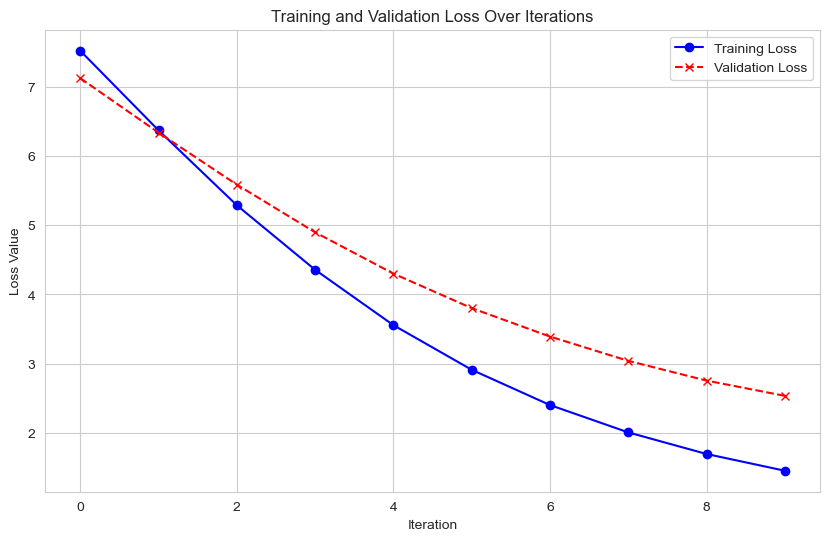

In [48]:
plot_loss_changes(pretrained_balance_train_loss, pretrained_balance_valid_loss)

In [49]:
pretrained_balance_conf, pretrained_balance_prob, pretrained_balance_acc = test_loop(pretrained_balance_model, test_loader)


100%|██████████| 53/53 [00:05<00:00, 10.28it/s]

Accuracy of the model on the test images: 9.35%


# Afterward Data Analysis Functions

In [50]:
import matplotlib.pyplot as plt

def collect_matched_items(predictions, confidences, label_map, one_hot_labels):
    x = []
    y = []
    
    matching_indices = [i for i, pred in enumerate(predictions) if pred == one_hot_labels[i]]
    
    for idx in matching_indices:
        name = label_map[one_hot_labels[idx]]
        x.append(name)
        num_pics = all_names_df.loc[all_names_df['name'] == name, 'images'].tolist()[0]
        y.append(num_pics)
        print(f"Name: {name}\n"
              f"Predicted class: {predictions[idx]}, Confidence: {confidences[idx]:.4f}\n"
              f"Number of Pictures: {num_pics}\n")
        
    return x, y


def first_n_numimage(df, n):
    image_counts = df['images'].value_counts().sort_index().head(n)

    image_counts.plot(kind='bar')
    plt.title('Distribution of Names by Image Count')
    plt.xlabel('Number of Images per Name')
    plt.ylabel('Count of Names')
    plt.show()
    
    
def combine_list_to_df(x, y):
    df = pd.DataFrame({
        'names': x,
        'images': y
    })
    return df

In [51]:
def calc_percentile(df, target, operation):
    """
    Computes the percentage of rows in 'df' where 'images' meets a condition specified by 'operation' and 'target'.
    
    Parameters:
    - df: DataFrame with 'images' column.
    - target: Value(s) to compare against 'images'.
    - operation: 'less equal', 'greater', or 'in' to specify the comparison type.
    
    Returns:
    - Percentage of rows meeting the condition.
    """
    if operation == "less equal":
        operation += ' than'
        count_condition = (df['images'] <= target).sum()
    elif operation == "greater":
        operation += ' than'
        count_condition = (df['images'] > target).sum()
    elif operation == "in":
        count_condition = df['image'].isin(target).sum()
    else:
        raise Exception("Unknown Operation")
    total_rows = len(df)
    percentile = (count_condition / total_rows) * 100
    
    print(f"percentile of df {operation} {target} is {percentile}%")
    return percentile


def find_num_image_percentile(df, target_percentage):
    """
    Returns the 'images' value from a sorted DataFrame where the cumulative row count reaches 
    or exceeds a specified percentage of the total rows.

    Parameters:
    - df (pd.DataFrame): DataFrame with an 'images' column.
    - target_percentage (float): Target percentage of total rows.

    Returns:
    - Value from 'images' column at the target percentage row.
    """
    sorted_df = df.sort_values(by='images', ascending=True).reset_index(drop=True)
    sorted_df['cumulative_percentage'] = ((sorted_df.index + 1) / len(sorted_df)) * 100
    target_index = sorted_df[sorted_df['cumulative_percentage'] >= target_percentage].index.min()
    return sorted_df.loc[target_index, 'images']



# Cumulative Distribution Graphs

In [76]:
def plot_cumulative_graph(prob, conf, label_map, one_hot_labels):
    match_x, match_y = collect_matched_items(prob, conf, label_map, one_hot_labels)
    match_df = combine_list_to_df(match_x, match_y)
    print(f"Number of correct Prediction: {len(match_x)}")
    unique_values = sorted(match_df['images'].unique())
    percentiles = [calc_percentile(match_df, value, 'less equal') for value in unique_values]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(unique_values, percentiles, marker='o')
    plt.title('Cumulative Distribution of Image Counts')
    plt.xlabel('Image Count')
    plt.ylabel('Cumulative Percentage')
    plt.grid(True)
    plt.show()


def plot_cumulative_graph_2_in_1(prob1, conf1, prob2, conf2, label_map, one_hot_labels):
    match_x1, match_y1 = collect_matched_items(prob1, conf1, label_map, one_hot_labels)
    match_x2, match_y2 = collect_matched_items(prob2, conf2, label_map, one_hot_labels)
    match_df1 = combine_list_to_df(match_x1, match_y1)
    match_df2 = combine_list_to_df(match_x2, match_y2)
    print(f"Number of correct Prediction for Biased Dataset  : {len(match_x1)}")
    print(f"Number of correct Prediction for UnBiased Dataset: {len(match_x2)}")
    unique_value1 = sorted(match_df1['images'].unique())
    unique_value2 = sorted(match_df2['images'].unique())
    percentiles_1 = [calc_percentile(match_df1, value, 'less equal') for value in unique_value1]
    percentiles_2 = [calc_percentile(match_df2, value, 'less equal') for value in unique_value2]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(unique_value2, percentiles_2, label='Unbiased', marker='o', linestyle='-', color='b')
    plt.plot(unique_value1, percentiles_1, label='Biased', marker='x', linestyle='--', color='r')
    plt.title('Cumulative Distribution of Image Counts')
    plt.xlabel('Image Count')
    plt.ylabel('Cumulative Percentage')
    plt.legend()
    plt.grid(True)
    plt.show()

## Original Dataset Distribution

percentile of df less equal than 2 is 46.36904761904762%
percentile of df less equal than 3 is 63.69047619047619%
percentile of df less equal than 4 is 74.82142857142857%
percentile of df less equal than 5 is 81.48809523809524%
percentile of df less equal than 6 is 84.76190476190476%
percentile of df less equal than 7 is 87.08333333333333%
percentile of df less equal than 8 is 89.04761904761904%
percentile of df less equal than 9 is 90.5952380952381%
percentile of df less equal than 10 is 91.48809523809524%
percentile of df less equal than 11 is 92.44047619047619%
percentile of df less equal than 12 is 93.03571428571429%
percentile of df less equal than 13 is 93.69047619047619%
percentile of df less equal than 14 is 94.28571428571428%
percentile of df less equal than 15 is 94.94047619047619%
percentile of df less equal than 16 is 95.11904761904762%
percentile of df less equal than 17 is 95.5952380952381%
percentile of df less equal than 18 is 95.89285714285715%
percentile of df less eq

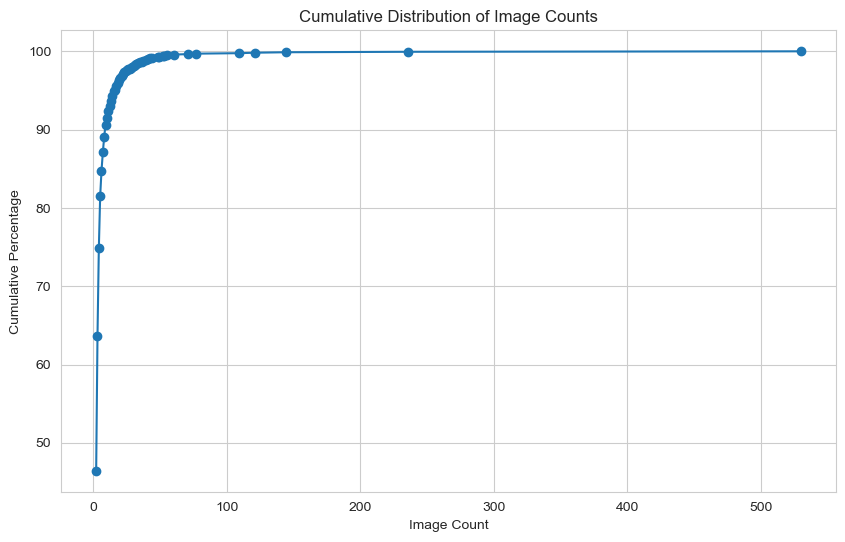

In [53]:
unique_values = sorted(all_image_df['images'].unique())
percentiles = [calc_percentile(all_image_df, value, 'less equal') for value in unique_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(unique_values, percentiles, marker='o')
plt.title('Cumulative Distribution of Image Counts')
plt.xlabel('Image Count')
plt.ylabel('Cumulative Percentage')
plt.grid(True)
plt.show()

## custom_unbalance

Name: George_W_Bush
Predicted class: 532, Confidence: 0.0699
Number of Pictures: 530

Number of correct Prediction: 1
percentile of df less equal than 530 is 100.0%


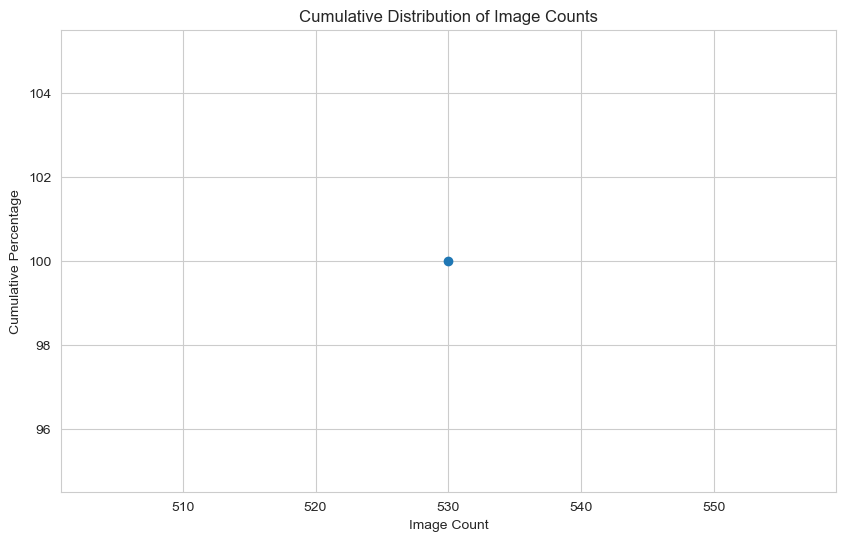

In [54]:
plot_cumulative_graph(custom_unbalance_prob, custom_unbalance_conf, test_label_map, one_hot_test_labels)

## custom_balance

Name: Melanie_Griffith
Predicted class: 1086, Confidence: 0.0008
Number of Pictures: 3

Number of correct Prediction: 1
percentile of df less equal than 3 is 100.0%


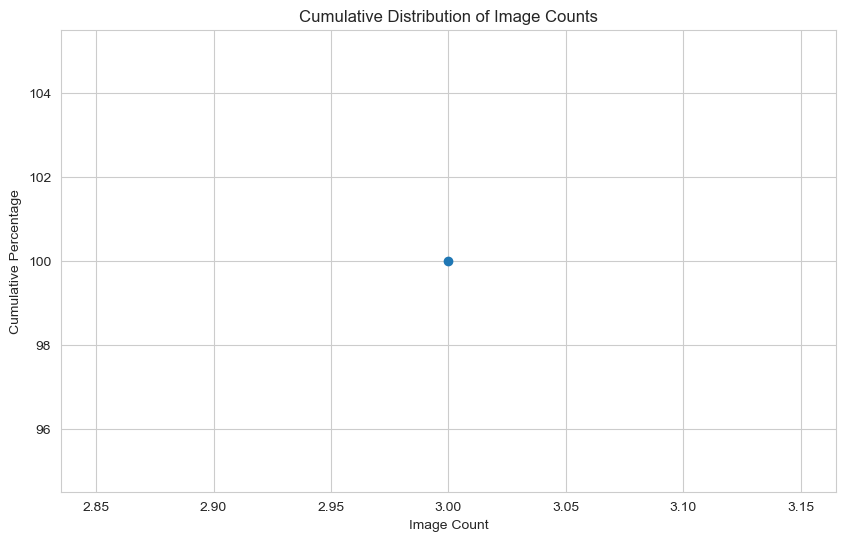

In [55]:
plot_cumulative_graph(custom_balance_prob, custom_balance_conf, test_label_map, one_hot_test_labels)

## pretrained ResNet-34 unbalance

Name: Albert_Costa
Predicted class: 34, Confidence: 0.2730
Number of Pictures: 6

Name: Alvaro_Uribe
Predicted class: 64, Confidence: 0.2410
Number of Pictures: 35

Name: Andre_Agassi
Predicted class: 78, Confidence: 0.9579
Number of Pictures: 36

Name: Andy_Roddick
Predicted class: 85, Confidence: 0.1740
Number of Pictures: 15

Name: Ari_Fleischer
Predicted class: 109, Confidence: 0.7233
Number of Pictures: 13

Name: Ariel_Sharon
Predicted class: 111, Confidence: 0.9629
Number of Pictures: 77

Name: Atal_Bihari_Vajpayee
Predicted class: 127, Confidence: 0.8288
Number of Pictures: 24

Name: Bill_Clinton
Predicted class: 160, Confidence: 0.1250
Number of Pictures: 29

Name: Bill_Gates
Predicted class: 162, Confidence: 0.0379
Number of Pictures: 17

Name: Bill_Graham
Predicted class: 163, Confidence: 0.7580
Number of Pictures: 9

Name: Binyamin_Ben-Eliezer
Predicted class: 173, Confidence: 0.1251
Number of Pictures: 7

Name: Bob_Stoops
Predicted class: 185, Confidence: 0.1662
Number of P

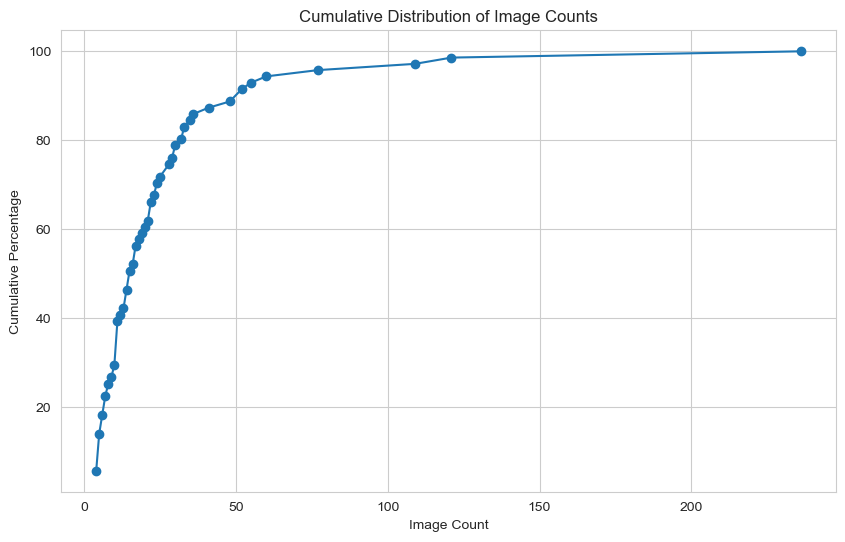

In [56]:
plot_cumulative_graph(pretrained_unbalance_prob, pretrained_unbalance_conf, test_label_map, one_hot_test_labels)

## pretrained ResNet-34 balance

Name: Abid_Hamid_Mahmud_Al-Tikriti
Predicted class: 9, Confidence: 0.0908
Number of Pictures: 3

Name: Alan_Ball
Predicted class: 30, Confidence: 0.3017
Number of Pictures: 2

Name: Alan_Greenspan
Predicted class: 31, Confidence: 0.0657
Number of Pictures: 5

Name: Alice_Fisher
Predicted class: 55, Confidence: 0.0630
Number of Pictures: 2

Name: Amber_Tamblyn
Predicted class: 68, Confidence: 0.2165
Number of Pictures: 2

Name: Angela_Merkel
Predicted class: 88, Confidence: 0.0365
Number of Pictures: 5

Name: Anthony_LaPaglia
Predicted class: 102, Confidence: 0.0626
Number of Pictures: 2

Name: Arnold_Palmer
Predicted class: 115, Confidence: 0.1424
Number of Pictures: 3

Name: Augusto_Pinochet
Predicted class: 129, Confidence: 0.0469
Number of Pictures: 2

Name: Azra_Akin
Predicted class: 132, Confidence: 0.1139
Number of Pictures: 4

Name: Biljana_Plavsic
Predicted class: 157, Confidence: 0.3311
Number of Pictures: 3

Name: Bill_Graham
Predicted class: 163, Confidence: 0.0351
Number of

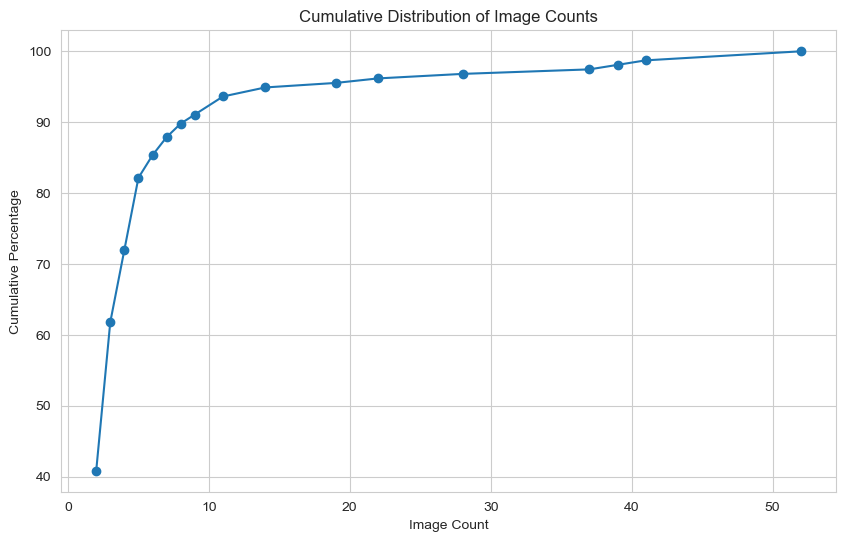

In [57]:
plot_cumulative_graph(pretrained_balance_prob, pretrained_balance_conf, test_label_map, one_hot_test_labels)

Name: Albert_Costa
Predicted class: 34, Confidence: 0.2730
Number of Pictures: 6

Name: Alvaro_Uribe
Predicted class: 64, Confidence: 0.2410
Number of Pictures: 35

Name: Andre_Agassi
Predicted class: 78, Confidence: 0.9579
Number of Pictures: 36

Name: Andy_Roddick
Predicted class: 85, Confidence: 0.1740
Number of Pictures: 15

Name: Ari_Fleischer
Predicted class: 109, Confidence: 0.7233
Number of Pictures: 13

Name: Ariel_Sharon
Predicted class: 111, Confidence: 0.9629
Number of Pictures: 77

Name: Atal_Bihari_Vajpayee
Predicted class: 127, Confidence: 0.8288
Number of Pictures: 24

Name: Bill_Clinton
Predicted class: 160, Confidence: 0.1250
Number of Pictures: 29

Name: Bill_Gates
Predicted class: 162, Confidence: 0.0379
Number of Pictures: 17

Name: Bill_Graham
Predicted class: 163, Confidence: 0.7580
Number of Pictures: 9

Name: Binyamin_Ben-Eliezer
Predicted class: 173, Confidence: 0.1251
Number of Pictures: 7

Name: Bob_Stoops
Predicted class: 185, Confidence: 0.1662
Number of P

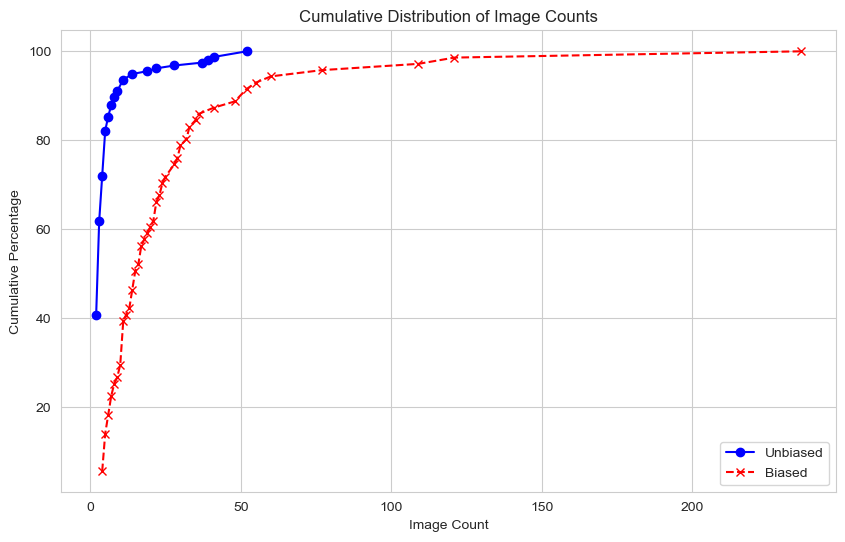

In [77]:
plot_cumulative_graph_2_in_1(pretrained_unbalance_prob, pretrained_unbalance_conf, pretrained_balance_prob, pretrained_balance_conf, test_label_map, one_hot_test_labels)

Name: George_W_Bush
Predicted class: 532, Confidence: 0.0651
Number of Pictures: 530

Name: Akbar_Hashemi_Rafsanjani
Predicted class: 24, Confidence: 0.9803
Number of Pictures: 3

Name: Alan_Ball
Predicted class: 30, Confidence: 0.9301
Number of Pictures: 2

Name: Chris_Bell
Predicted class: 274, Confidence: 0.8703
Number of Pictures: 2

Name: Elizabeth_Shue
Predicted class: 429, Confidence: 0.5698
Number of Pictures: 2

Name: Fernando_Gonzalez
Predicted class: 472, Confidence: 0.8425
Number of Pictures: 9

Name: Hee-Won_Han
Predicted class: 603, Confidence: 0.9849
Number of Pictures: 3

Name: Jane_Kaczmarek
Predicted class: 684, Confidence: 0.9257
Number of Pictures: 2

Name: Jason_Lezak
Predicted class: 692, Confidence: 0.8097
Number of Pictures: 2

Name: Jennifer_Reilly
Predicted class: 726, Confidence: 0.4519
Number of Pictures: 2

Name: Jeremy_Shockey
Predicted class: 731, Confidence: 0.5989
Number of Pictures: 2

Name: Jodie_Foster
Predicted class: 758, Confidence: 0.3646
Number 

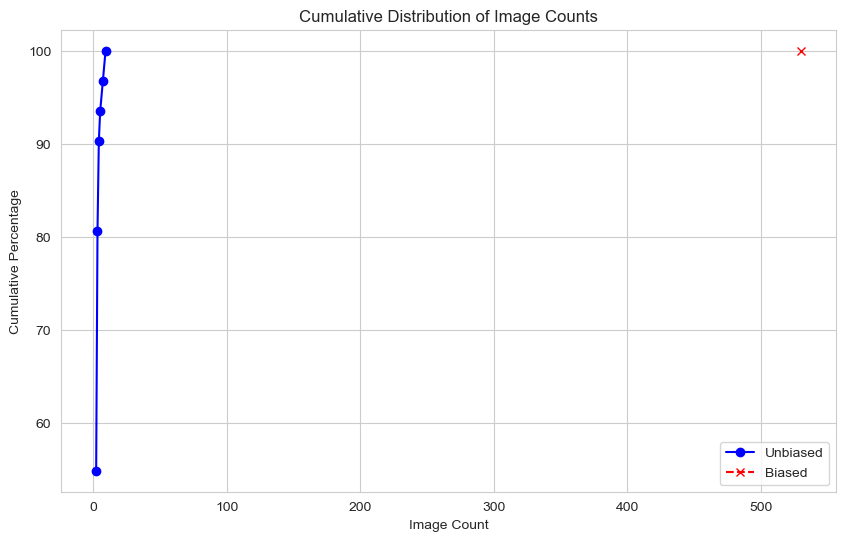

In [78]:
plot_cumulative_graph_2_in_1(custom_unbalance_prob, custom_unbalance_conf, custom_balance_prob, custom_balance_conf, test_label_map, one_hot_test_labels)